# ML-7. Тестовое задание по оптимизации гиперпараметров модели

## 1. Введение

Цели задания:
* Применить базовые способы оптимизации гиперпараметров (GridSearchCV, RandomSearchCV);
* Применить продвинутые способами оптимизации (Hyperopt, Optuna);
* Сделать настроку и обучить модели с их использованием,  так, чтобы улучшать итоговую метрику.  
* Провести сравнение сравнение результатов каждого из методов


## 2. Базовая оптимизация

In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

### Знакомство с данными и их исследование

In [2]:
#РАБОТАЕМ В IDE
data = pd.read_csv('data set/_train_sem09 (1).csv')

data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

In [3]:
data.isnull().sum()

Activity    0
D1          0
D2          0
D3          0
D4          0
           ..
D1772       0
D1773       0
D1774       0
D1775       0
D1776       0
Length: 1777, dtype: int64

Смотрим на сбалансированность классов:

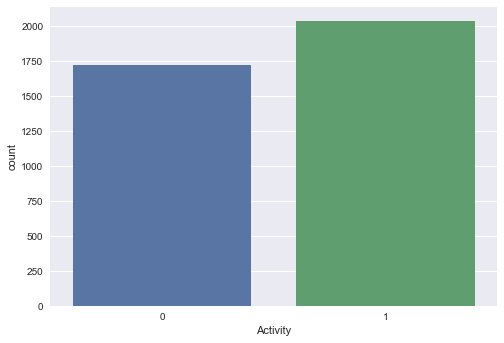

In [4]:
sns.countplot(data=data, x='Activity');

### Подготовка данных (предобработка)

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [5]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 80/20. Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.2)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [7]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 50)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
print('accuracy на тестовом наборе: {:.2f}'.format(log_reg.score(X_test, y_test)))
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78


c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### <center> **GridSearchCV**

Чтобы воспользоваться классом GridSearchCV:
- сначала необходимо импортировать библиотеку; 
- затем указать искомые гиперпараметры в виде словаря: ключами словаря являются имена настраиваемых гиперпараметров, а значениями – тестируемые настройки гиперпараметров; 
- после передаем модель (LogisticRegression), сетку искомых параметров (param_grid), а также число фолдов, которые мы хотим использовать в кросс-валидации, (допустим, пятиблочную кросс-валидацию, cv=5) и n_jobs = -1, чтобы использовать все доступные ядра для расчетов.

Созданный нами объект grid_search аналогичен классификатору, мы можем вызвать стандартные методы fit, predict и score от его имени. Однако, когда мы вызываем fit, он запускает кросс-валидацию для каждой комбинации гиперпараметров, указанных в param_grid.

GridSearchCV включает в себя не только поиск лучших параметров, но и автоматическое построение новой модели на всем обучающем наборе данных, используя параметры, которые дают наилучшее значение точности при кросс-валидации.


In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {'penalty': ['l2', 'none'] ,#тип регурялизации
              'solver': ['lbfgs', 'saga'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    estimator=linear_model.LogisticRegression(
        random_state=42, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test, y_test)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: total: 7.55 s
Wall time: 42.1 s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'penalty': 'l2', 'solver': 'saga'}


c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [9]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_1.score(X_test, y_test)))
y_test_pred = grid_search_1.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: total: 12 s
Wall time: 5min 33s
accuracy на тестовом наборе: 0.76
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Метрику опять не удалось улучшить, а время потратили много, в 5 раз больше!**

Поиск по сетке не гарантирует, что мы найдем наилучшую комбинацию гиперпараметров, а все потому что сетка значений конечна и фактическое наилучшее значение может отсутствовать или оказаться между значений, заданными нами.


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [10]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=50, random_state=42, solver='saga')


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

In [11]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.76


In [12]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.932847,0.431250,0.061061,0.008240,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.793333,0.776667,0.736667,0.765,0.74,0.762333,0.021592,5
1,7.768338,0.128845,0.059459,0.015555,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.795000,0.776667,0.736667,0.765,0.74,0.762667,0.022076,4


In [13]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

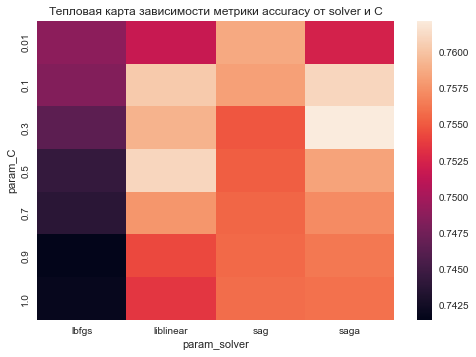

In [14]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что слабая регуляризация С = 0,01 отрицательно влияет на метрику, поэтому есть смысл брать значения 0,3 и алгоритмы оптимизации liblinear и saga работают лучше.

### <center> **RandomizedSearchCV**

В отличие от GridSearchCV, не все комбинации гиперпараметров проверяются, а только заданное количество комбинаций выбирается из указанных распределений. Количество комбинаций гиперпараметров задается n_iter.

С использованием класса RandomizedSearchCV из библиотеки scikit learn мы осуществим оптимизацию гиперпараметров для алгоритмов логистической регрессии, дерева решений и случайного леса, а также сравним результаты с GridSearchCV и значениями по умолчанию.

In [15]:
from sklearn.model_selection import RandomizedSearchCV

#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 0.1, 1, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search.score(X_test, y_test)))
y_test_pred = random_search.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CPU times: total: 6.81 s
Wall time: 24.9 s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01}


c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [16]:
param_grid = {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test, y_test)))
y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: total: 7.88 s
Wall time: 6min 13s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


c:\Users\penzin_kv\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


#### **Дерево решений**

Проделаем аналогичное для DecisionTreeClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [17]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(random_state=42)
#Обучаем дерево по алгоритму CARTrint
dt.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = dt.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = dt.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.75


Теперь зададим сетку гиперпараметров:  
*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;
*  'criterion' - критерий информативности

И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [18]:
param_distributions = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
random_search_tree = RandomizedSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 50, 
    n_jobs = -1
)  
%time random_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(random_search_tree.score(X_test, y_test)))
y_test_pred = random_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_tree.best_params_))

CPU times: total: 2.61 s
Wall time: 1min 7s
accuracy на тестовом наборе: 0.73
f1_score на тестовом наборе: 0.77
Наилучшие значения гиперпараметров: {'min_samples_leaf': 70, 'max_depth': 12, 'criterion': 'gini'}


In [19]:
param_grid = {'min_samples_leaf': list(np.linspace(5, 100, 50, dtype=int)),
              'max_depth': list(np.linspace(1, 30, 50, dtype=int)),
              'criterion':['entropy','gini']
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_tree.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test, y_test)))
y_test_pred = grid_search_tree.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

CPU times: total: 3min 19s
Wall time: 2h 6min 51s
accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.77
Наилучшие значения гиперпараметров: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 6}


Метрику удалось улучшить  с помощью обоих методов, но RandomizedSearchCV потребовалось меньше времени;

#### **Случайный лес**

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [20]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.80


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение;




И посчитаем RandomizedSearchCV() и затем GridSearchCV()





In [21]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: total: 4.27 s
Wall time: 57.7 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'n_estimators': 110, 'min_samples_leaf': 5, 'max_depth': 20}


In [22]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: total: 5.11 s
Wall time: 1min 53s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 20, 'min_samples_leaf': 5, 'n_estimators': 140}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

#### **Вывод по базовой оптимизации:**
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

### <center> Hyperopt

In [23]:
# Устанавливаем библиотеку
# !pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

In [55]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt

from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [25]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 300, 1),
       'max_depth' : hp.quniform('max_depth', 15, 40, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 3, 7, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [26]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    score = metrics.f1_score(y, model.predict(X))
    
    # обучать модель можно также с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    # score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [27]:
%%time

trials = Trials() # используется для логирования результатов

best = fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [02:08<00:00,  6.42s/trial, best loss: -0.9743433109346366]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 3.0, 'n_estimators': 201.0}
CPU times: total: 2min 4s
Wall time: 2min 8s


In [28]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.97
accuracy на тестовом наборе: 0.78
f1_score на тестовом наборе: 0.80


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

In [42]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=50, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.default_rng(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 50/50 [03:23<00:00,  7.55s/trial, best loss: -0.9750304506699147]
Наилучшие значения гиперпараметров {'max_depth': 28.0, 'min_samples_leaf': 3.0, 'n_estimators': 296.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

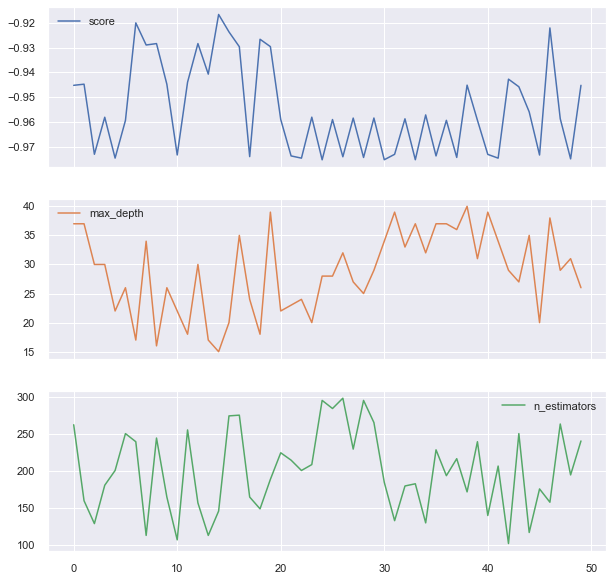

In [43]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10))

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [44]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [45]:
import optuna

Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [46]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  

In [47]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-10-11 12:57:10,469] A new study created in memory with name: RandomForestClassifier
[I 2022-10-11 12:57:13,941] Trial 0 finished with value: 0.9210206561360875 and parameters: {'n_estimators': 150, 'max_depth': 25, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9210206561360875.
[I 2022-10-11 12:57:18,179] Trial 1 finished with value: 0.9287020109689215 and parameters: {'n_estimators': 170, 'max_depth': 20, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9287020109689215.
[I 2022-10-11 12:57:20,981] Trial 2 finished with value: 0.9552238805970149 and parameters: {'n_estimators': 100, 'max_depth': 35, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.9552238805970149.
[I 2022-10-11 12:57:25,622] Trial 3 finished with value: 0.9206445728184859 and parameters: {'n_estimators': 200, 'max_depth': 35, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9552238805970149.
[I 2022-10-11 12:57:31,339] Trial 4 finished with value: 0.9585870889159561 and parameters: {'n_

CPU times: total: 1min 48s
Wall time: 1min 50s


In [48]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 260, 'max_depth': 30, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 0.97


In [49]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.81


In [50]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-10-11 12:59:14,413] Trial 20 finished with value: 0.9591712370505788 and parameters: {'n_estimators': 220, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 10 with value: 0.9747336377473363.
[I 2022-10-11 12:59:20,071] Trial 21 finished with value: 0.9746719560573696 and parameters: {'n_estimators': 210, 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.9747336377473363.
[I 2022-10-11 12:59:26,626] Trial 22 finished with value: 0.9744058500914077 and parameters: {'n_estimators': 250, 'max_depth': 33, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.9747336377473363.
[I 2022-10-11 12:59:32,130] Trial 23 finished with value: 0.9746719560573696 and parameters: {'n_estimators': 210, 'max_depth': 40, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.9747336377473363.
[I 2022-10-11 12:59:39,047] Trial 24 finished with value: 0.9585870889159561 and parameters: {'n_estimators': 280, 'max_depth': 28, 'min_samples_leaf': 4}. Best is trial 10 with va

CPU times: total: 58.1 s
Wall time: 58.3 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [51]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [52]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [53]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [56]:
optuna.visualization.plot_contour(study,
                                  params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.














